In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pickle as pkl
from os.path import join as oj

import dvu
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import ceil
from tqdm import tqdm
import numpy as np
import matplotlib.patches as patches
import sys
import pickle as pkl
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import statistics
from collections import defaultdict
sys.path.append('..')

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
while os.getcwd().split('/')[-1] != 'figs':
    os.chdir('..')

from config.figs_ensembles.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
import viz

print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from functools import partial
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, BaggingRegressor,AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegressionCV, RidgeCV
from imodels.experimental.figs_ensembles import FIGSExtClassifier, FIGSExtRegressor
from util import ModelConfig
from xgboost import XGBClassifier
from imodels.util.data_util import get_clean_dataset


num_datasets 14 0


In [2]:
def get_XGBoostsplits(m):
    m.get_booster().dump_model('xgb_model.txt', with_stats=True)
# read the contents of the file
    with open('xgb_model.txt', 'r') as f:
        txt_model = f.read()
# trying to extract all patterns like "[f2<2.45]"
    splits = re.findall('\[f([0-9]+)<([0-9]+.[0-9]+)\]', txt_model)
    return len(splits)

In [3]:
def get_RFsplits(rf):
    split_count = 0 
    for i in range(rf.n_estimators):
        split_count += rf.estimators_[i].tree_.node_count - rf.estimators_[i].tree_.n_leaves
    return split_count

In [4]:
def get_FIGSsplits(m):
    feats = []
    threshes = []
    nodes = [root for root in m.trees_]
    while len(nodes) > 0:
        n = nodes.pop()
        if n.left is not None or n.right is not None:
            feats.append(n.feature)
            threshes.append(n.threshold)
        if n.left is not None:
            nodes.append(n.left)
        if n.right is not None:
            nodes.append(n.right)
    return len(threshes)

In [5]:
def get_BaggingFIGSsplits(Bagging_FIGS):
    split_count = 0
    for i in range(Bagging_FIGS.n_estimators):
        split_count += get_FIGSsplits(Bagging_FIGS.estimators_[i])
    return split_count

In [6]:
def get_num_splits_for_model(model,model_type,n_reps = 3):
    splits_dict = {}
    for dset in DATASETS_CLASSIFICATION:
        splits_dict[dset[0]] = []
    for i in range(n_reps):
        for dset in DATASETS_CLASSIFICATION:
            print(dset[0])
            X,y,feat_names = get_clean_dataset(dset[1], dset[2])
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
            model.fit(X_train,y_train)
            if model_type == 'Bagging_FIGS':
                splits_dict[dset[0]].append(get_BaggingFIGSsplits(model))
            if model_type == 'Bagging_FIGS_CV':
                splits_dict[dset[0]].append(get_BaggingFIGSsplits(model.best_estimator_))
            if model_type == 'rf':
                splits_dict[dset[0]].append(get_RFsplits(model))
            if model_type == 'xgb':
                splits_dict[dset[0]].append(get_XGBoostsplits(model))
    return splits_dict
                


In [7]:
def get_split_stats(splits_dict):
    av_splits_dict = []
    std_splits_dict = []
    for dset in DATASETS_CLASSIFICATION:
        av_splits_dict.append(statistics.mean(splits_dict[dset[0]]))
        std_splits_dict.append(statistics.stdev(splits_dict[dset[0]]))
    return av_splits_dict,std_splits_dict

In [8]:
RF_splits = get_num_splits_for_model(model = RandomForestClassifier(),model_type = "rf",n_reps = 3)


sonar
heart
breast-cancer
haberman
ionosphere
diabetes
german-credit
csi-pecarn
juvenile
recidivism
iai-pecarn
credit
tbi-pecarn
readmission
sonar
heart
breast-cancer
haberman
ionosphere
diabetes
german-credit
csi-pecarn
juvenile
recidivism
iai-pecarn
credit
tbi-pecarn
readmission
sonar
heart
breast-cancer
haberman
ionosphere
diabetes
german-credit
csi-pecarn
juvenile
recidivism
iai-pecarn
credit
tbi-pecarn
readmission


In [9]:
av_RF_splits,std_RF_splits = get_split_stats(RF_splits)

In [10]:
xgb_splits =  get_num_splits_for_model(model = XGBClassifier(),model_type = "xgb",n_reps = 3)



sonar
[09:34:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
heart


/Users/abhineetagarwal/miniforge3/envs/biohubEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
breast-cancer
[09:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
haberman
[09:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ionosphere
[09:34:31] WARN

In [11]:
av_xgb_splits,std_xgb_splits = get_split_stats(xgb_splits)

In [13]:
m = GridSearchCV(estimator= BaggingClassifier(FIGSExtClassifier(max_features="sqrt"),n_estimators=100),param_grid= {'base_estimator__max_rules':[1,4,8,16,32]},cv=3)
Bagging_FIGS_CV_splits= get_num_splits_for_model(model = m, model_type="Bagging_FIGS_CV",n_reps=3)


sonar
heart
breast-cancer
haberman
ionosphere
diabetes
german-credit
csi-pecarn
juvenile
recidivism
iai-pecarn
credit
tbi-pecarn
readmission
sonar
heart
breast-cancer
haberman
ionosphere
diabetes
german-credit
csi-pecarn
juvenile
recidivism
iai-pecarn
credit
tbi-pecarn
readmission
sonar
heart
breast-cancer
haberman
ionosphere
diabetes
german-credit
csi-pecarn
juvenile
recidivism
iai-pecarn
credit
tbi-pecarn
readmission


In [ ]:
m.best_estimator_

In [15]:
av_Bagging_FIGS_CV_splits, std_Bagging_FIGS_CV_splits = get_split_stats(Bagging_FIGS_CV_splits)

# Plot 

In [16]:
dsets = list(RF_splits.keys())
dsets = [x.capitalize().replace('-', ' ')
         .replace('Tbi', 'TBI')
         .replace('Iai', 'IAI')         
         .replace('Csi', 'CSI')                  
         for x in dsets]

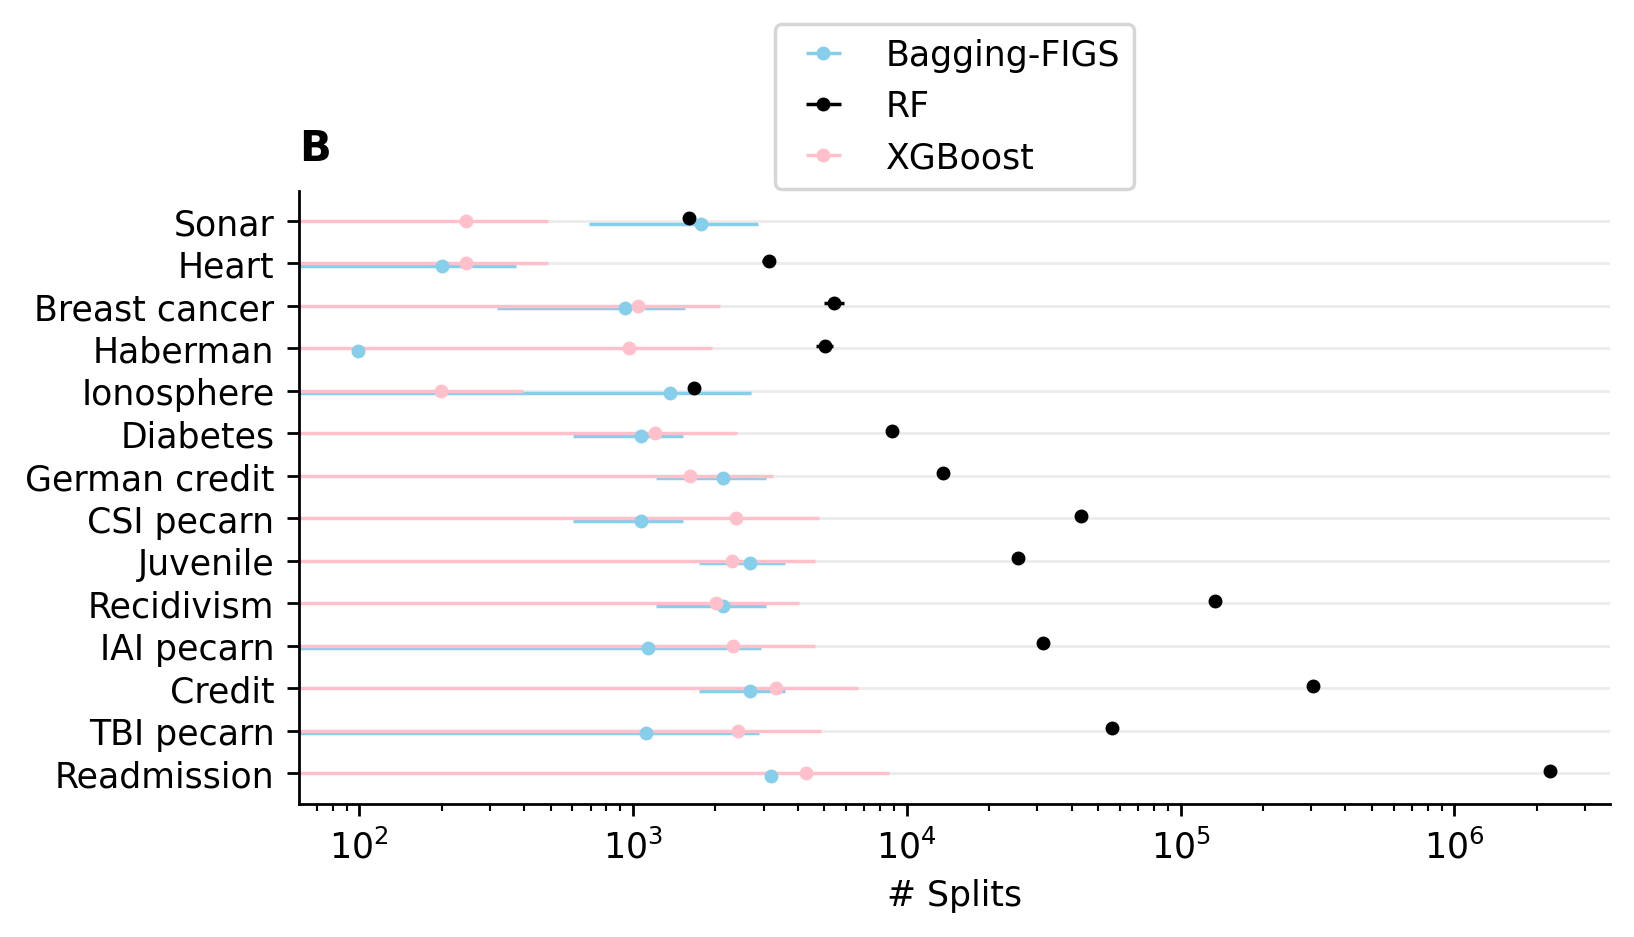

In [18]:
plt.figure(figsize=(12, 4), facecolor='w')
ax = plt.subplot(121)
elinewidth = 1
linedelta = elinewidth/2

y = np.arange(len(DATASETS_CLASSIFICATION))[::-1]
#z = r[r['name'] == 'Bagging-FIGS']
plt.errorbar(x=av_Bagging_FIGS_CV_splits, y=y-0.06, fmt='.', xerr=std_Bagging_FIGS_CV_splits, color='skyblue', alpha=1, label='Bagging-FIGS', elinewidth=elinewidth)
#z = r[r['name'] == 'FIGS']
plt.errorbar(x=av_RF_splits, y=y+0.06, fmt='.', xerr=std_RF_splits, color='black', alpha=1, label='RF', elinewidth=elinewidth)
#z = r[r['name'] == 'CART']
#print(z['rocauc_test_std'])
plt.errorbar(x=av_xgb_splits, y=y, fmt='.', xerr=av_xgb_splits, color='pink', alpha=1, label='XGBoost', elinewidth=elinewidth)

plt.xlabel('# Splits')
ax.set_xscale('log')
plt.yticks(y, labels=dsets)
plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center')
#plt.xlim((0.6, 1))
plt.text(0, 1.05, 'B', transform=ax.transAxes, fontweight='bold', fontsize='large')
plt.grid(axis='y', alpha=0.25)
plt.tight_layout(pad=1)